In [1]:
import pandas as pd
import numpy as np
import chardet
import matplotlib.pyplot as plt
import seaborn as sns
import streamlit as st
import pyarrow as pa
import pyarrow.parquet as pq
import time
import csv
import io
import os
from concurrent.futures import ThreadPoolExecutor, as_completed
from functools import partial
csv.field_size_limit(int(1e9)) 
import warnings
warnings.filterwarnings("ignore")

In [28]:
def processed_file_analysis(filename):
    df = pd.read_csv(filename + '_processed_sheet' + '.csv')
    df.rename(columns={'A': 'Timing'}, inplace=True)
    df['Timing'] = pd.to_datetime(df['Timing'], format='%Y-%m-%d %H:%M:%S:%f')
    df['Milliseconds'] = df['Timing'].dt.microsecond // 1000
    df['Time Diff'] = df['Milliseconds'].diff().fillna(10.0)
    df.loc[df['Time Diff'] < 0, 'Time Diff'] = 10.0
    
    return df

def process_row(row, S5=0):
    try:
        # Read the first column and convert the next three elements to float
        A = row[0]
        B, C, D = map(float, row[1:4])
    except ValueError as e:
#         print(f"Non-numeric data: {row[:4]}")  # Print the first four elements for context
        return None

    # Skip rows where B, C, and D are all zero
    if B == 0 and C == 0 and D == 0:
        return None
    
    angle_360 = np.sign(B) * np.arccos(-D / np.sqrt(B**2 + D**2)) * 180 / np.pi + 180
    angle_updown = np.arcsin(C / np.sqrt(B**2 + C**2 + D**2)) * 180 / np.pi
    body_rotation = "supine-recline" if S5 < angle_360 < (S5 + 180) else "prone-sit"
    
    if body_rotation == "prone-sit":
        if angle_updown > 0:
            prone_sit_class = "prone"
        elif angle_updown > -23:
            prone_sit_class = "prone supported"
        elif angle_updown > -63:
            prone_sit_class = "upright"
        else:
            prone_sit_class = "sitting"
        supine_recline_class = ""
    else:
        if angle_updown > 15:
            supine_recline_class = "upsidedown"
        elif angle_updown < -36:
            supine_recline_class = "reclined"
        elif angle_360 < (S5 + 69):
            supine_recline_class = "left side"
        elif angle_360 > (S5 + 101):
            supine_recline_class = "right side"
        else:
            supine_recline_class = "supine"
        prone_sit_class = ""
    
    overall_class = prone_sit_class + supine_recline_class
    
    return [A, B, C, D, angle_360, angle_updown, body_rotation, prone_sit_class, supine_recline_class, overall_class]

def process_dataset(file):
    """
    Process a large dataset from a CSV file.
    
    :param file: Name of the CSV file (without .csv extension)
    """
    output_file = file.rsplit('.', 1)[0] + '_processed_sheet.csv'
    
    file = file + '.csv'
#     total_rows = 0
#     processed_rows = 0
#     empty_rows = 0
#     invalid_rows = 0
    
    with open(file, 'rb') as infile, open(output_file, 'w', newline='') as outfile:
        # Read the file in binary mode
        content = infile.read()
        
        # Try to decode with utf-8, replacing errors
        text_content = content.decode('utf-8', errors='replace')
        
        # Create a CSV reader from the decoded content
        reader = csv.reader(io.StringIO(text_content))
        writer = csv.writer(outfile)
        
        # Skip header rows
        for _ in range(100):
            next(reader, None)
        
        # Write header
        writer.writerow(['A','B','C','D','360 angle','Up/down angle',
                         'Body Rotation','Prone-sit class','Supine-recline class','Overall class'])
        
        process_row_partial = partial(process_row)
        for row in reader:
#             total_rows += 1
#             if not row:  # Check for completely empty rows
#                 empty_rows += 1
#                 continue
            
            processed_row = process_row_partial(row)
            if processed_row:
                writer.writerow(processed_row)
#                 processed_rows += 1
#             else:
#                 invalid_rows += 1
    
    print(f"Processing complete. Results saved as {output_file} in the current folder")
#     print(f"Total rows read: {total_rows}")
#     print(f"Rows successfully processed: {processed_rows}")
#     print(f"Empty rows skipped: {empty_rows}")
#     print(f"Invalid rows skipped: {invalid_rows}")

def dataset_description(df):
    
    class_counts = df['Overall class'].fillna('NaN').groupby(df['Overall class'].fillna('Missing Rows')).count().reset_index(name='Class Count')
    class_counts['Duration in seconds'] = class_counts['Class Count'] / 100
    class_counts = class_counts[['Overall class', 'Duration in seconds']]
    
    total_duration_seconds = class_counts['Duration in seconds'].sum()

    if total_duration_seconds >= 60:
        total_duration_minutes = total_duration_seconds / 60
        print(f"Duration of Video in Minutes: {total_duration_minutes:.2f}")
    else:
        print(f"Duration of Video in Seconds: {total_duration_seconds:.2f}")
    
    # statistics = df.describe()
    return class_counts, total_duration

def create_plot(df):
    class_counts = df['Overall class'].fillna('NaN').groupby(df['Overall class'].fillna('Missing Rows')).count().reset_index(name='Class Count')
    class_counts['Duration in seconds'] = class_counts['Class Count'] / 100
    
    fig, ax = plt.subplots(figsize=(8, 6))  # Create figure and axes objects
    bars = ax.bar(class_counts['Overall class'], class_counts['Duration in seconds'])
    
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 1, round(yval, 2), ha='center', va='bottom')
    
    ax.set_xticklabels(class_counts['Overall class'], rotation=45)
    ax.set_yticks([])
    ax.set_xlabel('Category')
    ax.set_ylabel('Duration in Seconds')
    sns.despine(ax=ax, bottom=True, left=True)

    plt.show()
    
    # st.pyplot(fig)  # Provide the figure to st.pyplot

def plot_bins(df, class_name):
    same_class_mask = df['Overall class'] == df['Overall class'].shift(1)
    df['Increment'] = np.where(same_class_mask, 10, 0)
    df['Rolling Sum'] = df['Increment'].groupby((~same_class_mask).cumsum()).cumsum() / 1000
    df.drop(columns=['Increment'], inplace=True)
    
    d = df[df['Overall class'] == class_name].copy()
    
    # If there are no rows for the given class
    if d.empty:
        return(f"No values for class '{class_name}' exist.")
#         st.warning(f"No values for class '{class_name}' exist.")
#         return
    
    max_val = d['Rolling Sum'].max()
    
    fixed_bins = [0.1, 0.2, 0.3, 0.4, 0.5, 1]
    variable_bins = np.linspace(1.5, max(max_val, 1.5), num=5)
    bins = np.unique(np.sort(np.concatenate((fixed_bins, variable_bins))))
    
    d['duration_bin'] = pd.cut(d['Rolling Sum'], bins, include_lowest=True)
    
    cnt_bin = d.groupby(['Overall class', 'duration_bin']).size().reset_index(name='bin_count')
    
    # Check if all bin counts are zero
    if cnt_bin['bin_count'].sum() == 0:
        st.warning(f"No values for class '{class_name}' exist.")
        return
    
    cnt_bin['duration_bin'] = cnt_bin['duration_bin'].astype(str)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(x='duration_bin', height='bin_count', data=cnt_bin)
    
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 1, round(yval, 2), ha='center', va='bottom')
    
    ax.set_title(f"Buckets for: {class_name}")
    ax.set_xticklabels(cnt_bin['duration_bin'], rotation=45, ha='right')
    ax.set_yticks([])
    ax.set_xlabel('Duration (seconds)')
    ax.set_ylabel('Count')
    sns.despine(ax=ax, bottom=True, left=True)
    plt.tight_layout()

    plt.show()
    # st.pyplot(fig)
    
def overall_class_stats(df, overall_class):
    class_indices = df[df['Overall class'] == overall_class].index
    cnt_arr = []
    cnt = max_cnt = 1
    start = end = class_indices[0]
    
    for i in range(len(class_indices) - 1):
        if class_indices[i + 1] == class_indices[i] + 1:
            cnt += 1
            max_cnt = max(cnt, max_cnt)
        else:
            end = class_indices[i]
            formatted_output = f"{start} to {end}: {cnt}"
            cnt_arr.append(formatted_output)
            start = class_indices[i + 1]
            cnt = 1
    
    end = class_indices[-1]
    formatted_output = f"{start} to {end}: {cnt}"
    cnt_arr.append(formatted_output)
    
    max_sequence = max(cnt_arr, key=lambda x: int(x.split(': ')[1]))
    
    return cnt_arr, max_sequence

def display_dataset(df):
    return df.head()

In [ ]:
folder_path = input("Enter folder path : ")
os.chdir(folder_path)

In [ ]:
os.getcwd()

# Enter File Name Here

In [3]:
file_name = input("Enter file name : ")

Enter file name : E1_right hip_102373_2024-08-27 14-57-00


In [ ]:
process_dataset(file_name)

In [4]:
df = processed_file_analysis(file_name)
display_dataset(df)

,Timing,B,C,D,360 angle,Up/down angle,Body Rotation,Prone-sit class,Supine-recline class,Overall class
0,2024-08-22 10:16:32.000,-0.0159,-0.5170,-0.8473,178.924943,-31.385951,supine-recline,NaN,right side,right side
1,2024-08-22 10:16:32.010,-0.0360,-0.5130,-0.8315,177.520913,-31.648845,supine-recline,NaN,right side,right side
2,2024-08-22 10:16:32.020,-0.0400,-0.5210,-0.8354,177.258700,-31.920416,supine-recline,NaN,right side,right side
3,2024-08-22 10:16:32.030,-0.0199,-0.5250,-0.8196,178.609124,-32.634184,supine-recline,NaN,right side,right side
4,2024-08-22 10:16:32.040,-0.0279,-0.5130,-0.8038,178.012054,-32.531130,supine-recline,NaN,right side,right side
...,...,...,...,...,...,...,...,...,...,...
8878113,2024-08-23 10:59:13.950,-0.0119,-1.0089,0.0397,16.686003,-87.647639,supine-recline,NaN,reclined,reclined
8878114,2024-08-23 10:59:13.960,-0.0159,-1.0169,0.0476,18.471052,-87.174670,supine-recline,NaN,reclined,reclined
8878115,2024-08-23 10:59:13.970,-0.0199,-1.0249,0.0397,26.622751,-87.518958,supine-recline,NaN,reclined,reclined
8878116,2024-08-23 10:59:13.980,-0.0239,-1.0249,0.0357,33.801034,-87.599689,supine-recline,NaN,reclined,reclined


In [39]:
df['Timing'].max() - df['Timing'].min()
# 88781.18000000001/3600

Timedelta('1 days 00:42:41.990000')

In [43]:
(8878118*10)/1000

88781.18

In [44]:
88781.18/3600

24.66143888888889

# Analysis

In [5]:
dataset_description(df)

Duration of Video: 88781.18000000001


(     Overall class  Duration in seconds
 0        left side             11821.77
 1            prone              7358.38
 2  prone supported             23284.75
 3         reclined              5489.66
 4       right side             18288.63
 5          sitting              6489.18
 6           supine               430.54
 7          upright             12269.78
 8       upsidedown              3348.49,
 88781.18000000001)

In [ ]:
df[df['Overall class']]

In [45]:
print("Duration in Hours : ",88781.18000000001/3600)

Duration in Hours :  24.661438888888892


In [ ]:
class_name = input("Enter Class name : ")

In [ ]:
overall_class_stats(df,class_name)

# Graphs

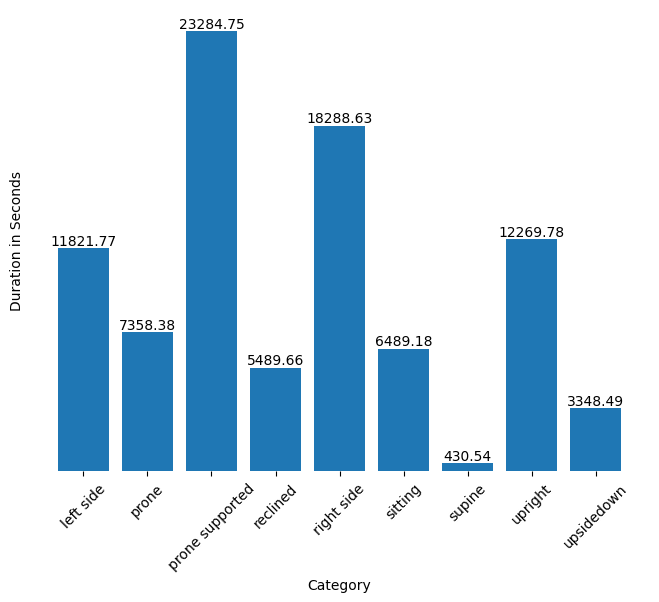

In [20]:
create_plot(df)

In [62]:
# list(df[df['Overall class']=='sitting'].index)

In [61]:
consequtive_rows(df,'sitting')

['428 to 428: 1',
 '3584 to 3594: 11',
 '3598 to 3608: 11',
 '3647 to 3658: 12',
 '3723 to 3723: 1',
 '3756 to 3756: 1',
 '3777 to 3777: 1',
 '3780 to 3781: 2',
 '3783 to 3785: 3',
 '3869 to 3878: 10',
 '3880 to 3889: 10',
 '3892 to 3899: 8',
 '3905 to 3907: 3',
 '3915 to 3917: 3',
 '3923 to 3925: 3',
 '3943 to 3963: 21',
 '3989 to 3989: 1',
 '3991 to 3999: 9',
 '4002 to 4002: 1',
 '4004 to 4004: 1',
 '4016 to 4016: 1',
 '4018 to 4096: 79',
 '4099 to 4101: 3',
 '4129 to 4131: 3',
 '4133 to 4133: 1',
 '4187 to 4188: 2',
 '4249 to 4249: 1',
 '4251 to 4251: 1',
 '4265 to 4267: 3',
 '4280 to 4281: 2',
 '4308 to 4311: 4',
 '4321 to 4321: 1',
 '4374 to 4375: 2',
 '4377 to 4377: 1',
 '4424 to 4427: 4',
 '4437 to 4438: 2',
 '4444 to 4444: 1',
 '4457 to 4457: 1',
 '4473 to 4473: 1',
 '4489 to 4495: 7',
 '4498 to 4502: 5',
 '4532 to 4535: 4',
 '4581 to 4585: 5',
 '4597 to 4598: 2',
 '4601 to 4782: 182',
 '4787 to 4826: 40',
 '4831 to 4831: 1',
 '4837 to 4854: 18',
 '4870 to 4897: 28',
 '4903 to 

In [31]:
position_name = input("Enter Class name : ")

Enter Class name : prone


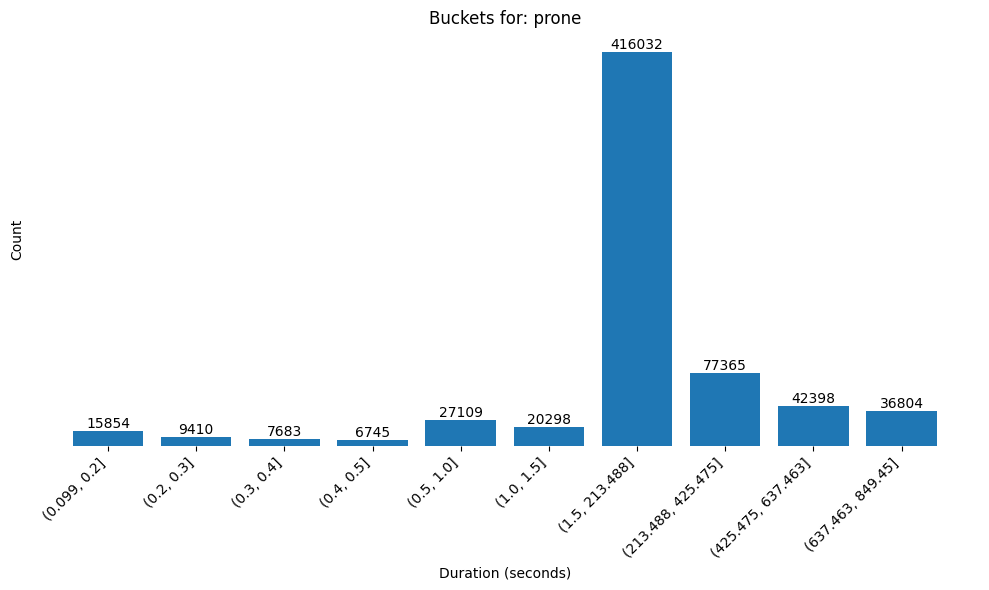

In [32]:
plot_bins(df,position_name)